In [3]:
import numpy as np
import pandas as pd
import pyarrow

from pandas_profiling import ProfileReport

from ipyleaflet import * 
from ipyleaflet import (
    Map, TileLayer, SplitMapControl, Marker, basemaps, MarkerCluster, Choropleth
)

import pandas as pd
#import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import holidays
from datetime import timedelta
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

us_ca_holidays = holidays.UnitedStates(state="CA", years=range(2010, 2025))


In [6]:
#df = pd.read_parquet('./data/safety-SanFrancisco.parquet') 
df = pd.read_parquet('./data/safety-SanFrancisco-2.parquet') 
df = df.drop(['dataType', 'extendedProperties'], axis=1)
for col in ["dataSubtype", "category", "subcategory"]:
    df[col] = pd.Categorical(df[col])
df['dateTime'] = pd.to_datetime(df['dateTime'], format='%Y%m%d %H:%M:%S')

df = pd.DataFrame.drop_duplicates(df)

top_categories = pd.Series(['Street and Sidewalk Cleaning'
                            #'Potentially Life-Threatening'
                            #,'Graffiti'
                            #,'Encampments'
                            #,'Street and Sidewalk Cleaning'
                            #,'Non Life-threatening'
                           ])
df = df[df['category'].isin(top_categories)]

mask = (
    (df["dateTime"] >= pd.to_datetime("2015-01-01")) & (df["dateTime"] < pd.to_datetime("2019-12-31"))
)

#df = df[mask]
#df.index=df['dateTime']

#df['DayOfWeek']=df["dateTime"].dt.day_name()
df['DayOfWeek']=df["dateTime"].dt.dayofweek
df['Hour']=df["dateTime"].dt.hour
df['Month']=df["dateTime"].dt.month
df['Day']=df["dateTime"].dt.day
df['Year']=df["dateTime"].dt.year
df['DayOfYear']=df["dateTime"].dt.dayofyear

holiday_eve = []
for date in us_ca_holidays.keys():
    holiday_eve.append(date - timedelta(days=1))
    
df['is_holiday']=df["dateTime"].dt.date.isin(holiday_eve)
df.head()

,requestId,dataSubtype,dateTime,category,subcategory,status,address,latitude,longitude,source,neighborhood,DayOfWeek,Hour,Month,Day,Year,DayOfYear,is_holiday
1,2,311_All,2018-07-08 15:00:27,Street and Sidewalk Cleaning,Bulky Items,Closed,"1536 SACRAMENTO ST, SAN FRANCISCO, CA, 94109",37.791887,-122.418188,Mobile/Open311,Nob Hill,6,15,7,8,2018,189,False
5,12,311_All,2020-04-10 12:45:00,Street and Sidewalk Cleaning,Medical Waste,Closed,"4 TURK ST, SAN FRANCISCO, CA, 94102",37.783520,-122.409487,Web,Tenderloin,4,12,4,10,2020,101,False
10,30,311_All,2019-01-02 17:35:00,Street and Sidewalk Cleaning,City_garbage_can_overflowing,Closed,Intersection of BEACH ST and HYDE ST,37.806656,-122.420563,Phone,Nob Hill,2,17,1,2,2019,2,False
15,43,311_All,2019-07-23 12:04:00,Street and Sidewalk Cleaning,General Cleaning,Closed,"180 PENNSYLVANIA AVE, SAN FRANCISCO, CA, 94107",37.764300,-122.393714,Mobile/Open311,South Beach,1,12,7,23,2019,204,False
22,57,311_All,2018-06-27 10:55:00,Street and Sidewalk Cleaning,General Cleaning,Closed,"850 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109",37.788984,-122.415220,Mobile/Open311,Nob Hill,2,10,6,27,2018,178,False


In [7]:
df_weather = pd.read_parquet("./data/weather-data-SF-Nyc-Seattle-2015-2020.parquet")
df_weather["date"] = pd.to_datetime(df_weather["date"], format="%Y%m%d")

df_weather = df_weather[df_weather["station"] == "USW00023234"]
df_weather.head()
df_weather.shape
#profile = ProfileReport(df_weather, title="Pandas Profiling Report")
#profile



(12641, 4)

In [8]:
df_weather = df_weather.set_index(["date", "field"])["value"].unstack(-1)
df_weather = df_weather.fillna(method="ffill").fillna(method="bfill")

df_weather.head()


field,AWND,PRCP,SNWD,TAVG,TMAX,TMIN,WSF2
date,,,,,,,
2015-01-01,38.0,0.0,0.0,97.0,128.0,44.0,89.0
2015-01-02,7.0,0.0,0.0,77.0,111.0,33.0,31.0
2015-01-03,7.0,0.0,0.0,77.0,122.0,33.0,31.0
2015-01-04,9.0,0.0,0.0,86.0,128.0,50.0,63.0
2015-01-05,11.0,0.0,0.0,98.0,150.0,61.0,31.0


In [9]:
df["date"] = df["dateTime"].dt.date

df_weather["date_merge"] = df_weather.index.date
    
df2 = df.merge(df_weather, left_on="date", right_on="date_merge", how="left")
df2.shape

del df2["date_merge"]


In [10]:
df = df2

In [13]:
df.tail()

,requestId,dataSubtype,dateTime,category,subcategory,status,address,latitude,longitude,source,...,DayOfYear,is_holiday,date,AWND,PRCP,SNWD,TAVG,TMAX,TMIN,WSF2
965963,1203128,311_All,2017-02-21 10:04:45,Street and Sidewalk Cleaning,General Cleaning,Closed,Intersection of PACIFIC AVE and TRENTON ST,37.796595,-122.409287,Mobile/Open311,...,52,False,2017-02-21,53.0,74.0,0.0,141.0,161.0,100.0,143.0
965964,1203136,311_All,2020-06-29 12:36:00,Street and Sidewalk Cleaning,Bulky Items,Closed,"1024 POTRERO AVE, SAN FRANCISCO, CA, 94110",37.755692,-122.406784,Phone,...,181,False,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
965965,1203161,311_All,2018-12-10 21:33:49,Street and Sidewalk Cleaning,Bulky Items,Closed,"1024 JACKSON ST, SAN FRANCISCO, CA, 94133",37.795492,-122.412033,Mobile/Open311,...,344,False,2018-12-10,16.0,5.0,0.0,102.0,144.0,78.0,63.0
965966,1203168,311_All,2017-08-20 09:53:26,Street and Sidewalk Cleaning,Bulky Items,Closed,Intersection of WOOLSEY ST and HAMILTON ST,37.723687,-122.408529,Phone,...,232,False,2017-08-20,43.0,0.0,0.0,189.0,222.0,161.0,81.0
965967,1203173,311_All,2019-03-19 14:14:18,Street and Sidewalk Cleaning,Bulky Items,Closed,"1293 WEBSTER ST, SAN FRANCISCO, CA, 94115",37.782656,-122.431373,Web,...,78,False,2019-03-19,31.0,0.0,0.0,133.0,206.0,94.0,125.0


In [11]:
#df = df.drop(['requestId', 'dataSubtype', 'source', 'latitude', 'longitude', 'address', 'status', 'subcategory'], axis=1)

#df = df.drop(['Month', 'Hour', 'Day', 'DayOfWeek', 'requestId', 'dataSubtype', 'source', 'latitude', 'longitude', 'address', 'status', 'subcategory'], axis=1)
#df.index=df['dateTime']
#df.drop(['dateTime'])

top_neighborhood = pd.Series(['Mission'
                            ,'SoMa'
                            ,'Tenderloin'
                            ,'Nob Hill'
                            ,'Ingleside'
                           ])

df = df[df['neighborhood'].isin(top_neighborhood)]

agg_func = {'neighborhood': ['count']}

#agg = df.groupby([pd.Grouper(key='dateTime', freq='4h'), 'neighborhood']).agg(agg_func).reset_index()

agg = df.groupby([pd.Grouper(key='dateTime', freq='7D'), 
                  'neighborhood', 'Year', 
                  'Month', 'Hour', 'Day', 
                  'DayOfWeek', 'DayOfYear', 
                  'AWND','PRCP','SNWD','TAVG',
                  'TMAX','TMIN','WSF2'])["requestId"].count().reset_index().rename(columns={"requestId": "count"})
  
    
#df.groupby(["dateTime", "neighborhood"]).agg(agg_func).head()
#agg.reset_index()
agg.sort_values("dateTime")


,dateTime,neighborhood,Year,Month,Hour,Day,DayOfWeek,DayOfYear,AWND,PRCP,SNWD,TAVG,TMAX,TMIN,WSF2,count
0,2016-01-01,Ingleside,2016,1,1,6,2,6,51.0,251.0,0.0,108.0,128.0,89.0,116.0,1
288,2016-01-01,SoMa,2016,1,11,6,2,6,51.0,251.0,0.0,108.0,128.0,89.0,116.0,5
287,2016-01-01,SoMa,2016,1,11,5,1,5,43.0,254.0,0.0,119.0,128.0,100.0,107.0,1
286,2016-01-01,SoMa,2016,1,11,4,0,4,28.0,28.0,0.0,100.0,144.0,83.0,94.0,14
285,2016-01-01,SoMa,2016,1,11,3,6,3,9.0,10.0,0.0,88.0,117.0,67.0,40.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117627,2020-06-05,Mission,2020,6,23,5,4,157,51.0,0.0,0.0,171.0,317.0,144.0,125.0,1
117628,2020-06-05,Nob Hill,2020,6,6,5,4,157,51.0,0.0,0.0,171.0,317.0,144.0,125.0,1
117629,2020-06-05,Nob Hill,2020,6,7,5,4,157,51.0,0.0,0.0,171.0,317.0,144.0,125.0,3
117614,2020-06-05,Mission,2020,6,8,5,4,157,51.0,0.0,0.0,171.0,317.0,144.0,125.0,15


(17896.0, 18444.0)

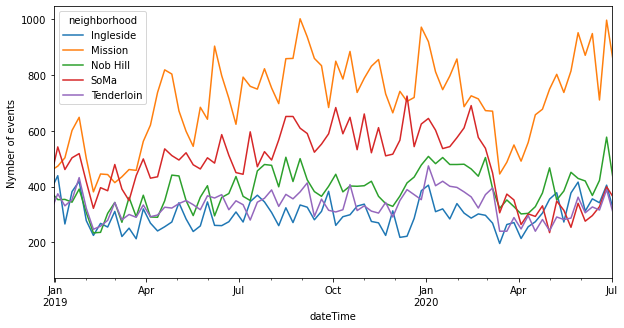

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

df.groupby([pd.Grouper(key="dateTime", freq="7D"), "neighborhood"])["requestId"].count().unstack().plot(ax=ax)

ax.set_ylabel("Nymber of events")
ax.set_xlim(pd.Timestamp("2018-12-31"), pd.Timestamp("2020-07-01"))

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
import sklearn
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    agg.sort_values("dateTime"), test_size=0.15, shuffle=False
)



In [10]:
df_train.tail()

,dateTime,neighborhood,Year,Month,Hour,Day,DayOfWeek,DayOfYear,AWND,PRCP,SNWD,TAVG,TMAX,TMIN,WSF2,count
89617,2019-06-11 16:00:00,SoMa,2019,6,16,11,1,162,37.0,0.0,0.0,261.0,367.0,194.0,98.0,5
89620,2019-06-11 16:00:00,SoMa,2019,6,19,11,1,162,37.0,0.0,0.0,261.0,367.0,194.0,98.0,3
89616,2019-06-11 16:00:00,Nob Hill,2019,6,19,11,1,162,37.0,0.0,0.0,261.0,367.0,194.0,98.0,2
89612,2019-06-11 16:00:00,Mission,2019,6,18,11,1,162,37.0,0.0,0.0,261.0,367.0,194.0,98.0,16
89614,2019-06-11 16:00:00,Nob Hill,2019,6,17,11,1,162,37.0,0.0,0.0,261.0,367.0,194.0,98.0,4


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
import sklearn
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OrdinalEncoder

column_transformer = ColumnTransformer(
    [
        (
            "cat", OrdinalEncoder(), ["neighborhood"],
        ),
        (
            "passthrough",
            "passthrough",
            ["Month", "Day", "DayOfWeek", "Hour", "DayOfYear", "Year", "AWND", "PRCP", "TAVG", "TMAX", "TMIN", "WSF2"],
        ),
    ]
)

def passthrugh(df):
    return df

pipe = make_pipeline(FunctionTransformer(passthrugh))
X_train = pipe.fit_transform(df_train)
X_test = pipe.transform(df_test)


#est = Ridge().fit(X_train, df_train["count"])

In [14]:
from sklearn.metrics import classification_report

df_test["predicted"] = est.predict(X_test)

est.score(X_test, df_test["count"])

del df_test["predicted"]

NameError: name 'est' is not defined

In [15]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

column_transformer = ColumnTransformer(
    [
        (
            "cat", OrdinalEncoder(), ["neighborhood"],
        ),
        (
            "passthrough",
            "passthrough",
            ["Month", "Day", "DayOfWeek", "Hour", "DayOfYear", "Year", "AWND", "PRCP", "TAVG", "TMAX", "TMIN", "WSF2"],
        ),
    ]
)

est2 = GradientBoostingRegressor()
pipeline = make_pipeline(column_transformer, est2)
#X_train = pipeline.fit_transform(df_train)
#X_test = pipeline.transform(df_test)


#est2 = HistGradientBoostingRegressor().fit(X_train, df_train["count"],)
pipeline.fit(
    X_train, df_train["count"],
)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['neighborhood']),
                                                 ('passthrough', 'passthrough',
                                                  ['Month', 'Day', 'DayOfWeek',
                                                   'Hour', 'DayOfYear', 'Year',
                                                   'AWND', 'PRCP', 'TAVG',
                                                   'TMAX', 'TMIN', 'WSF2'])])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [16]:
import eli5

pr_imp = permutation_importance(
    pipeline, X_test, df_test["count"], scoring="neg_root_mean_squared_error"
)

#eli5.show_weights(est2)
eli5.explain_weights(est2, feature_names=['neighborhood', 'Year', 'Month', 'Hour', 'Day', 'DayOfWeek',
       'DayOfYear', 'AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'WSF2'])


C:\Users\luke\.conda\envs\test9\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\luke\.conda\envs\test9\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.6093 ± 0.5459,Day
0.2541 ± 0.5579,neighborhood
0.0594 ± 0.2090,Hour
0.0351 ± 0.1947,DayOfYear
0.0176 ± 0.2079,DayOfWeek
0.0091 ± 0.1317,PRCP
0.0040 ± 0.0916,TMAX
0.0040 ± 0.1011,Month
0.0031 ± 0.0617,AWND
0.0018 ± 0.0531,TAVG


In [19]:
cv = TimeSeriesSplit(n_splits=60)

for train_idx, test_idx in  cv.split(agg.sort_values("dateTime")):
    df_train, df_test = agg.iloc[train_idx], agg.iloc[test_idx]
    print (df_train, df_test)
#

       dateTime neighborhood  Year  Month  Hour  Day  DayOfWeek  DayOfYear  \
0    2016-01-01    Ingleside  2016      1     1    6          2          6   
1    2016-01-01    Ingleside  2016      1     2    3          6          3   
2    2016-01-01    Ingleside  2016      1     3    4          0          4   
3    2016-01-01    Ingleside  2016      1     4    4          0          4   
4    2016-01-01    Ingleside  2016      1     4    5          1          5   
...         ...          ...   ...    ...   ...  ...        ...        ...   
1981 2016-01-29     Nob Hill  2016      2    18    4          3         35   
1982 2016-01-29     Nob Hill  2016      2    20    1          0         32   
1983 2016-01-29     Nob Hill  2016      2    21    1          0         32   
1984 2016-01-29     Nob Hill  2016      2    21    2          1         33   
1985 2016-01-29     Nob Hill  2016      2    21    4          3         35   

      AWND   PRCP  SNWD   TAVG   TMAX   TMIN   WSF2  count  
0 

        dateTime neighborhood  Year  Month  Hour  Day  DayOfWeek  DayOfYear  \
0     2016-01-01    Ingleside  2016      1     1    6          2          6   
1     2016-01-01    Ingleside  2016      1     2    3          6          3   
2     2016-01-01    Ingleside  2016      1     3    4          0          4   
3     2016-01-01    Ingleside  2016      1     4    4          0          4   
4     2016-01-01    Ingleside  2016      1     4    5          1          5   
...          ...          ...   ...    ...   ...  ...        ...        ...   
21261 2016-11-11   Tenderloin  2016     11    10   16          2        321   
21262 2016-11-11   Tenderloin  2016     11    10   17          3        322   
21263 2016-11-11   Tenderloin  2016     11    11   11          4        316   
21264 2016-11-11   Tenderloin  2016     11    11   13          6        318   
21265 2016-11-11   Tenderloin  2016     11    11   14          0        319   

       AWND   PRCP  SNWD   TAVG   TMAX   TMIN   WSF

[38618 rows x 16 columns]         dateTime neighborhood  Year  Month  Hour  Day  DayOfWeek  DayOfYear  \
38618 2017-07-28    Ingleside  2017      7     9   29          5        210   
38619 2017-07-28    Ingleside  2017      7     9   30          6        211   
38620 2017-07-28    Ingleside  2017      7     9   31          0        212   
38621 2017-07-28    Ingleside  2017      7    10   28          4        209   
38622 2017-07-28    Ingleside  2017      7    10   29          5        210   
...          ...          ...   ...    ...   ...  ...        ...        ...   
40541 2017-08-18         SoMa  2017      8     7   24          3        236   
40542 2017-08-18         SoMa  2017      8     8   18          4        230   
40543 2017-08-18         SoMa  2017      8     8   19          5        231   
40544 2017-08-18         SoMa  2017      8     8   20          6        232   
40545 2017-08-18         SoMa  2017      8     8   21          0        233   

       AWND  PRCP  SNWD  

        dateTime neighborhood  Year  Month  Hour  Day  DayOfWeek  DayOfYear  \
0     2016-01-01    Ingleside  2016      1     1    6          2          6   
1     2016-01-01    Ingleside  2016      1     2    3          6          3   
2     2016-01-01    Ingleside  2016      1     3    4          0          4   
3     2016-01-01    Ingleside  2016      1     4    4          0          4   
4     2016-01-01    Ingleside  2016      1     4    5          1          5   
...          ...          ...   ...    ...   ...  ...        ...        ...   
55965 2018-03-16   Tenderloin  2018      3    14   21          2         80   
55966 2018-03-16   Tenderloin  2018      3    15   16          4         75   
55967 2018-03-16   Tenderloin  2018      3    15   17          5         76   
55968 2018-03-16   Tenderloin  2018      3    15   18          6         77   
55969 2018-03-16   Tenderloin  2018      3    15   19          0         78   

       AWND   PRCP  SNWD   TAVG   TMAX   TMIN   WSF

[71394 rows x 16 columns]         dateTime neighborhood  Year  Month  Hour  Day  DayOfWeek  DayOfYear  \
71394 2018-10-05         SoMa  2018     10     9    9          1        282   
71395 2018-10-05         SoMa  2018     10     9   10          2        283   
71396 2018-10-05         SoMa  2018     10     9   11          3        284   
71397 2018-10-05         SoMa  2018     10    10    5          4        278   
71398 2018-10-05         SoMa  2018     10    10    6          5        279   
...          ...          ...   ...    ...   ...  ...        ...        ...   
73317 2018-11-02      Mission  2018     11     0    3          5        307   
73318 2018-11-02      Mission  2018     11     0    4          6        308   
73319 2018-11-02      Mission  2018     11     2    6          1        310   
73320 2018-11-02      Mission  2018     11     3    3          5        307   
73321 2018-11-02      Mission  2018     11     4    2          4        306   

       AWND  PRCP  SNWD  

[84890 rows x 16 columns]         dateTime neighborhood  Year  Month  Hour  Day  DayOfWeek  DayOfYear  \
84890 2019-04-05   Tenderloin  2019      4    11    7          6         97   
84891 2019-04-05   Tenderloin  2019      4    11    8          0         98   
84892 2019-04-05   Tenderloin  2019      4    11    9          1         99   
84893 2019-04-05   Tenderloin  2019      4    11   10          2        100   
84894 2019-04-05   Tenderloin  2019      4    11   11          3        101   
...          ...          ...   ...    ...   ...  ...        ...        ...   
86813 2019-05-03     Nob Hill  2019      5    11    7          1        127   
86814 2019-05-03     Nob Hill  2019      5    11    8          2        128   
86815 2019-05-03     Nob Hill  2019      5    11    9          3        129   
86816 2019-05-03     Nob Hill  2019      5    12    3          4        123   
86817 2019-05-03     Nob Hill  2019      5    12    4          5        124   

       AWND  PRCP  SNWD  

         dateTime neighborhood  Year  Month  Hour  Day  DayOfWeek  DayOfYear  \
0      2016-01-01    Ingleside  2016      1     1    6          2          6   
1      2016-01-01    Ingleside  2016      1     2    3          6          3   
2      2016-01-01    Ingleside  2016      1     3    4          0          4   
3      2016-01-01    Ingleside  2016      1     4    4          0          4   
4      2016-01-01    Ingleside  2016      1     4    5          1          5   
...           ...          ...   ...    ...   ...  ...        ...        ...   
100309 2019-10-18   Tenderloin  2019     10    18   20          6        293   
100310 2019-10-18   Tenderloin  2019     10    18   21          0        294   
100311 2019-10-18   Tenderloin  2019     10    18   22          1        295   
100312 2019-10-18   Tenderloin  2019     10    18   23          2        296   
100313 2019-10-18   Tenderloin  2019     10    19   18          4        291   

        AWND   PRCP  SNWD   TAVG   TMAX

[111882 rows x 16 columns]          dateTime neighborhood  Year  Month  Hour  Day  DayOfWeek  DayOfYear  \
111882 2020-03-20      Mission  2020      3    12   21          5         81   
111883 2020-03-20      Mission  2020      3    12   22          6         82   
111884 2020-03-20      Mission  2020      3    12   23          0         83   
111885 2020-03-20      Mission  2020      3    12   24          1         84   
111886 2020-03-20      Mission  2020      3    12   25          2         85   
...           ...          ...   ...    ...   ...  ...        ...        ...   
113805 2020-04-17    Ingleside  2020      4     4   17          4        108   
113806 2020-04-17    Ingleside  2020      4     4   18          5        109   
113807 2020-04-17    Ingleside  2020      4     4   19          6        110   
113808 2020-04-17    Ingleside  2020      4     4   20          0        111   
113809 2020-04-17    Ingleside  2020      4     4   21          1        112   

        AWND